Se tomatan muestras al azar del dataset de DRISHTI, al mismo se lo clasificará con el mejor modelo que tenemos *DRISHTI__augm_f-75_p-25* y se procedera a realizar el recorte de la zona disco-copa 

1. Levantar x cantidad de imagenes ala zar
2. clasificar el modelo
3. devolver la clasificacion a su tamano original
4. aplicar recorte de la mascara y de la imagen original
5. mostrar resultados (original, gt, prediction, recorte imagen, recorte mascara


In [25]:
import torch
import imageio as iio
import matplotlib.pyplot as plt
from data_processing import utils
from Models.Unet import Unet
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from PIL import Image
from skimage.transform import resize
import torch.nn as nn
from configparser import ConfigParser
import numpy as np
from sklearn.metrics import f1_score,accuracy_score
import torchvision.transforms.functional as FT
from skimage import filters, measure
import math
import glob
import random

In [26]:
def get_OCOD_crop(mask,delta):
    ''' dada la mascara de una imagen, calculo la zona del disco y la copa + un delta
    se toma la zona clasificada, de ella al lado mas largo (alto u ancho) se le agrega el factor alpha, 
    el lado restante se lo acomoda para que el resultado final sea una imagen cuadrada
    input --------------------
    mask: imagen binaria de la clasificacion
    delta: indice en porcentaje de que tanto mas de la mascara queremos dejan en los bordes'''

    blobs_labels = measure.label(mask, background=0)
    region = measure.regionprops(blobs_labels)[0]
        
    coordinates = region.bbox #(min_row, min_col, max_row, max_col)
    sub_h = coordinates[3]-coordinates[1]
    sub_w = coordinates[2]-coordinates[0]
    x = coordinates[1] + sub_h // 2
    y = coordinates[0] + sub_w // 2
    if sub_h > sub_w: #REVISAR LOS LIMITES
        c1 = int(coordinates[1] - coordinates[1] * delta)
        c3 = int(coordinates[3] + coordinates[3] * delta)
        new_h = c3 - c1 
        if (new_h % 2) != 0:
            new_h = new_h + 1
            c3 = c3 + 1
        new_w = new_h
        half = new_w / 2
        c0 = y - half
        c2 = y + half
    else:
        
        c0 = int(coordinates[0] - coordinates[0] * delta)
        c2 = int(coordinates[2] + coordinates[2] * delta)
        new_w = c2 - c0 
        if (new_w % 2) != 0:
            new_w = new_w + 1
            c2 = c2 + 1
        new_h = new_w
        half = new_w / 2
        c1 = x - half
        c3 = x + half
    h,w  = mask.shape

    #VERIFICO LIMITES
  
    if c2 > w:
        c2 = w
    if c3 > h:
        c3 = h
    if c0 < 0:
        c0 = 0
    if c1 < 0:
        c1 = 0
    return int(c0),int(c1),int(c2),int(c3), (x,y)

In [27]:
def rescale_test(fundus_img,y,target_radio):
    '''
    Reescalo la imagen de test para que, en vez de recortar las imagenes y reescalar, mantener un radio similar al que obtenemos con las imagenes de test(que fueron recortadas)
    generando una imagen cuadrada del tamano similar a las imagenes de test pero que no pasaron por un cut fov
    -------------------------------------------
    input:
    fundus_img: imagen de test original
    y: mascara correspondiente a la imagen original
    target_radio: radio en el que esperamos tener en la imagen
    
    a futuro- tener en cuenta que podemos llegar a tener que realizar este metodo pero sin tener una mascara, permitir que pueda venir un y=None 
    '''
    lim_x_inf,lim_x_sup, lim_y_inf,lim_y_sup, radio = utils.crop_fov_limits(fundus_img)
    
    width, height,_ = fundus_img.shape    
    scale = target_radio / radio

    new_width = int(scale*width)
    new_height = int(scale*height)
            
    scaledImg = resize(fundus_img, (new_width,new_height))
    y_rescale = resize(y, (new_width,new_height))
    
    size = max(new_width,new_height)
    squareImg = resize(scaledImg,(size,size))
    y_squared = resize(y_rescale,(size,size))
    
    
    return squareImg, y_squared

Obtengo 10 imagenes random para analizar el recorte de las imagenes

In [28]:
base_path =  '/mnt/Almacenamiento/ODOC_segmentation/data/'
img_paths = 'images/DRISHTI/'
OD_paths = 'OD1/DRISHTI/'
model = '/mnt/Almacenamiento/ODOC_segmentation/codigo/config_files/DRISHTI_augm_f-75_p-25.ini'

imagenes= []
masks=[]
for img_p in sorted(glob.glob(base_path + img_paths + '*.png')):
        imagenes.insert(len(imagenes), img_p)
for mask_p in sorted(glob.glob(base_path + OD_paths + '*.png')):
        masks.insert(len(masks), mask_p)
print(len(imagenes))
print(len(masks))
img2process = []
mask2process = []
values = random.sample(range(1, len(imagenes)), 10)
for i in values:
    print(i)
    img2process.insert(len(img2process),imagenes[i])
    mask2process.insert(len(mask2process),masks[i])
    

50
50
27
24
41
20
23
36
7
42
21
22


In [29]:
loss = nn.CrossEntropyLoss()
config_path = '/mnt/Almacenamiento/ODOC_segmentation/codigo/config_files/DRISHTI_augm_f-75_p-25.ini'
config = ConfigParser()
config.read(config_path)

model = Unet(config, loss, model_name='prueba')

path_best = '/mnt/Almacenamiento/ODOC_segmentation/codigo/lightning_logs/drishti_model/matrix/version_19/checkpoints/DRISHTI_augm_f-75_p-25-epoch=109.ckpt'

#CARGO MODELO
model = model.load_from_checkpoint(path_best, config= config, loss=loss, model_name='prueba')

In [30]:
predictions = []
binary_pred = []
imgs = []
masks = []
for idx in range(len(img2process)):
    img = iio.imread(img2process[idx])
    mask = iio.imread(mask2process[idx])
    imgs.append(img)
    masks.append(mask)
    mask[mask < 255] = 0
    
    img,mask = rescale_test(img,mask,255)
    #TRANSFORMO LA IMAGENE EN TENSOR
    transform = transforms.ToTensor()
    img = transform(img)
    img= img.float()
    shape = img.size()

    #NORMALIZO
    mean_r = torch.mean(img[0,:,:])
    mean_g = torch.mean(img[1,:,:])
    mean_b = torch.mean(img[2,:,:])

    std_r = torch.std(img[0,:,:])+1e-6
    std_g = torch.std(img[1,:,:])+1e-6
    std_b = torch.std(img[2,:,:])+1e-6

    img = F.normalize(img, [mean_r, mean_g, mean_b], [std_r,std_g, std_b]) #normalizo la imagen

    #AGREGO LA DIMENSION BATCH SIZE
    img= torch.unsqueeze(img, 0)

    #ARREGLAR LAS DIMENSIONES PARA QUE QUEDE EN 1, 3, W, H
    y_hat = model.forward(img)
    pred = model.softmax(y_hat)
    pred_arg = torch.argmax(pred, dim=1) #BINARY IMAGE OF THE SEGMENTATION
    
    img = model.generate_img(pred_arg,transform(mask) )
    img = img[:,0,:,:]
    img = np.transpose(img, (1, 2, 0))
    binary_img = np.transpose(pred_arg, (1, 2, 0))
    
    predictions.insert(len(predictions), img)
    binary_pred.insert(len(binary_pred),binary_img)

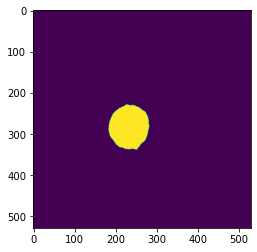

In [31]:
plt.imshow(binary_pred[9])

In [32]:
c0s = []
c1s = []
c2s = []
c3s = []
delta = 0.1
for idx in range(len(img2process)):
    img = imgs[idx]
    mask = masks[idx]
    h,w,c = img.shape
    #print(h, w, c)

    #plt.imshow(binary_pred[idx])
    #plt.show()

    scaledPred = resize(binary_pred[idx], (h,w),preserve_range=True)
    #plt.imshow(img)
    #plt.imshow(scaledPred,alpha=0.4)
    #plt.show()

    c0,c1,c2,c3, center = get_OCOD_crop(scaledPred[:,:,0],delta)
    print('Coordenadas: ',c0,c1,c2,c3)
    c0s.append(c0)
    c1s.append(c1)
    c2s.append(c2)
    c3s.append(c3)

    #plt.imshow(img[c0:c2,c1:c3])

    


Coordenadas:  571 867 1113 1409
Coordenadas:  623 765 1239 1381
Coordenadas:  726 684 1288 1246
Coordenadas:  829 734 1435 1340
Coordenadas:  783 526 1331 1074
Coordenadas:  593 589 1259 1255
Coordenadas:  621 565 1219 1163
Coordenadas:  748 731 1330 1313
Coordenadas:  674 680 1316 1322
Coordenadas:  684 541 1232 1089


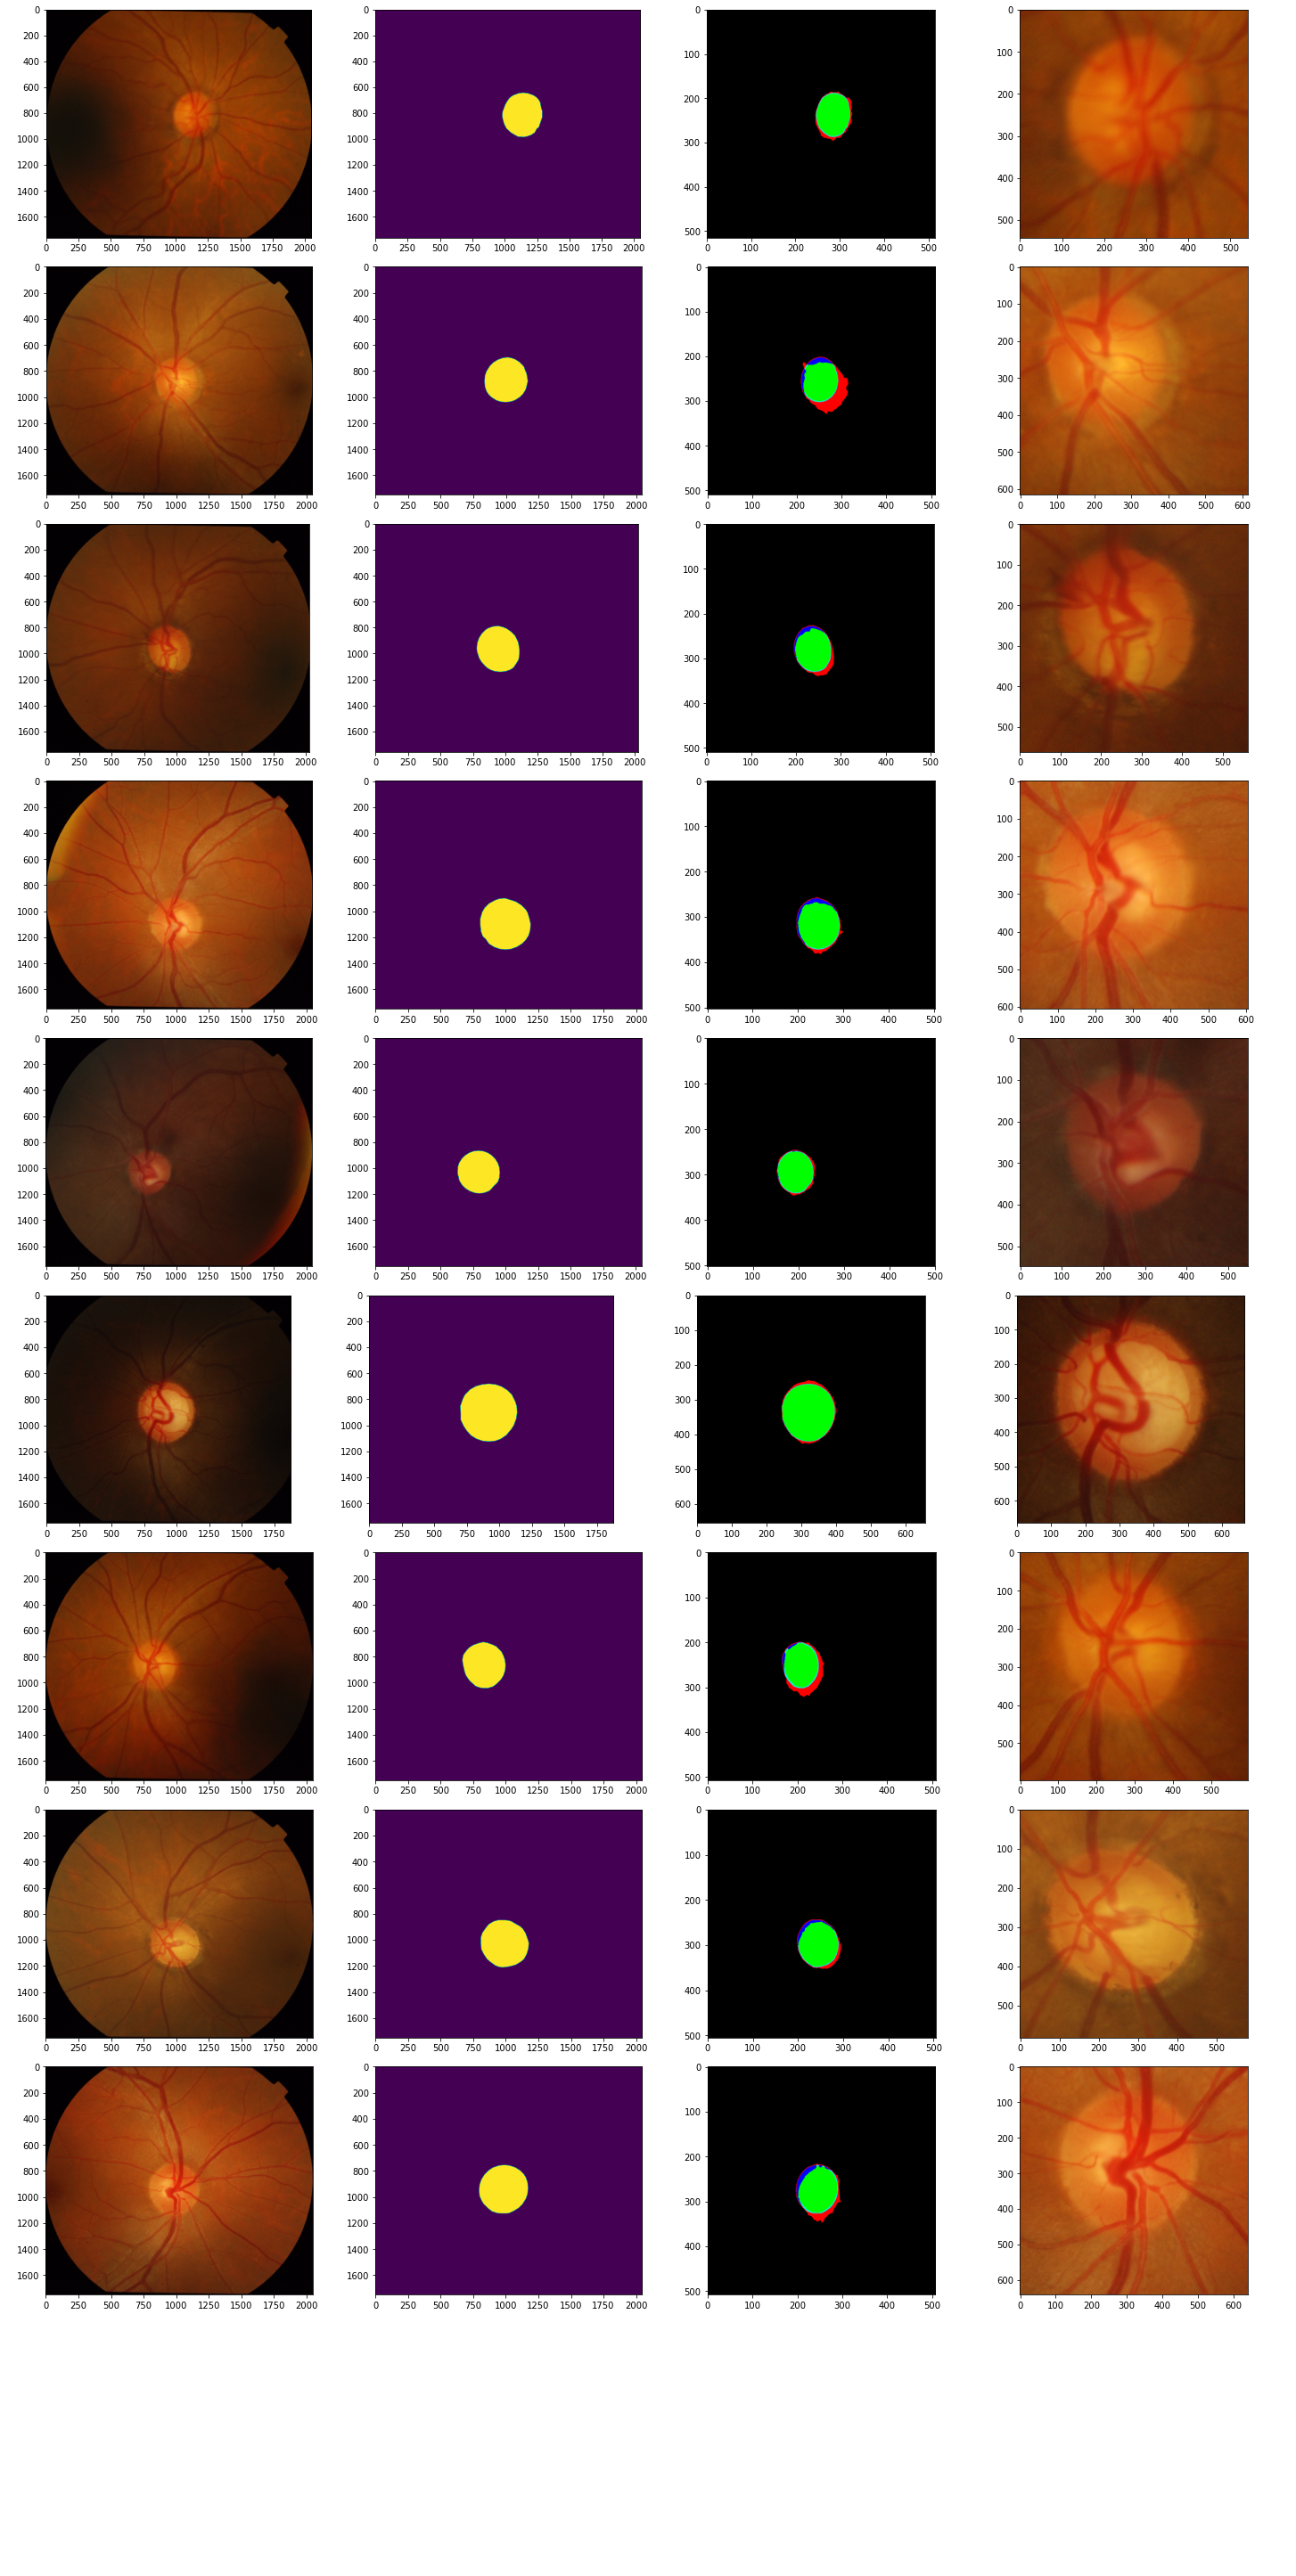

In [33]:
fig = plt.figure(constrained_layout=True,figsize=(20, 40))
subfigs = fig.subfigures(10, 1)

for i in range(9):
    (ax1, ax2, ax3, ax4) = subfigs[i].subplots(1,4)
    ax1.imshow(imgs[i])
    ax2.imshow(masks[i])
    ax3.imshow(predictions[i])
    new_img = (imgs[i])[c0s[i]:c2s[i],c1s[i]:c3s[i]]
    ax4.imshow(new_img)
    